In [2]:
import numpy as np 
import pandas as pd 
import os, re
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from functools import partial
from tensorflow.keras.applications import EfficientNetB3
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from subprocess import Popen
from os import chmod
from os.path import isfile
import json
import time
import psutil
from datetime import datetime

K = keras.backend
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
IMG_SIZE = 296
N_CLASSES = 101
PRETRAINED_MODEL_PATH = '../input/food101-pretr-model/model_pretrained(1).h5'
# Create a generator
GEN = tf.random.Generator.from_seed(42, alg='philox')

In [3]:
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

In [37]:
# remove logs and ngrok directories
#!rm -rf ./logs/
# run in case ngrok tunnel time ended 
#!rm -rf ./ngrok

In [38]:
!pip install -U tensorboard_plugin_profile

     |████████████████████████████████| 1.1 MB 927 kB/s eta 0:00:01


In [39]:
def launch_tensorboard():
    tb_process, ngrok_process = None, None
    
    # Launch TensorBoard
    if not is_process_running('tensorboard'):
        tb_command = 'tensorboard --logdir ./logs/ --host 0.0.0.0 --port 6006'
        tb_process = run_cmd_async_unsafe(tb_command)
    
    # Install ngrok
    if not isfile('./ngrok'):
        ngrok_url = 'https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip'
        download_and_unzip(ngrok_url)
        chmod('./ngrok', 0o755)
        !./ngrok authtoken 20n9VCoHURREqL7452NwHI3unVo_2xtgbrUXgrJpQVMUFSpGR

    # Create ngrok tunnel and print its public URL
    if not is_process_running('ngrok'):
        ngrok_process = run_cmd_async_unsafe('./ngrok http 6006')
        time.sleep(1) # Waiting for ngrok to start the tunnel
    ngrok_api_res = urlopen('http://127.0.0.1:4040/api/tunnels', timeout=10)
    ngrok_api_res = json.load(ngrok_api_res)
    assert len(ngrok_api_res['tunnels']) > 0, 'ngrok tunnel not found'
    tb_public_url = ngrok_api_res['tunnels'][0]['public_url']
    print(f'TensorBoard URL: {tb_public_url}')

    return tb_process, ngrok_process


def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)


def run_cmd_async_unsafe(cmd):
    return Popen(cmd, shell=True)


def is_process_running(process_name):
    running_process_names = (proc.name() for proc in psutil.process_iter())
    return process_name in running_process_names


tb_process, ngrok_process = launch_tensorboard()

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
TensorBoard URL: https://364a-34-105-34-178.ngrok.io


In [4]:
# exponential LR scheduler
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

# get model losses based on exponentially changed learning rate       
def find_learning_rate(model, X_y, num_inst, epochs=1, batch_size=32, min_rate=1e-6, max_rate=10):
    init_weights = model.get_weights()
    iterations = num_inst // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X_y, epochs=epochs, batch_size=batch_size,
                        steps_per_epoch=num_inst // batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

# log-LR / loss plot
def plot_lr_vs_loss(rates, losses, zoom):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / zoom])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

## Loading and Visualizing

In [5]:
# load the data with shuffling
dataset, info = tfds.load('food101', as_supervised=True, shuffle_files=True, 
                          with_info=True)

# output information about data splits
print(info.splits)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.vision.ee.ethz.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete2AND7N/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete2AND7N/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
{'train': <tfds.core.SplitInfo num_examples=75750>, 'validation': <tfds.core.SplitInfo num_examples=25250>}


In [6]:
# get data labels
class_names = info.features["label"].names
n_classes = len(class_names)
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [7]:
# split data using S3 split API
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "food101",
    split=["validation", "train[:15%]", "train[15%:]"],
    as_supervised=True)

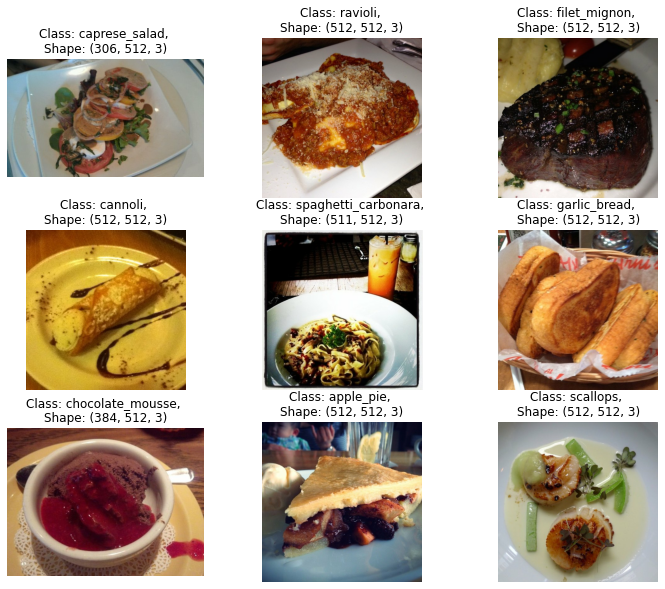

In [8]:
# visualize some data
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    #image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    plt.imshow(tf.cast(image, tf.uint8))
    #plt.imshow(image)
    plt.title("Class: {}, \nShape: {}".format(class_names[label], image.shape))
    plt.axis("off")

plt.show()

## Preprocessing

There are several ways to preprocess data: 
- apply preprocessing (custom function or keras preprocessing layer) to the dataset by calling map;
- include preprocessing directly inside model definition (simplify deployment).

In [9]:
# augmentation
def augment(image, batch_size=BATCH_SIZE):
    # Make a new seed
    seed = GEN.make_seeds(2)[0]
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]

    # Random flip
    image = tf.image.stateless_random_flip_left_right(image, new_seed)
    return image

# model specific preprocessing
def preprocess(image):
    resized_image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return keras.applications.efficientnet.preprocess_input(resized_image)

## Input pipelines

In [10]:
# configure datasets for performance
def prepare(ds, batch_size=BATCH_SIZE, shuffle=False, augmentation=False):
    
    ds = ds.map(lambda x, y: (tf.image.resize_with_crop_or_pad(
        x, IMG_SIZE+200, IMG_SIZE+200), y), num_parallel_calls=AUTOTUNE)
    
    # shuffle training dataset
    if shuffle:
        ds = ds.shuffle(1024)
    
    # vectorize transformations
    ds = ds.batch(batch_size, drop_remainder=True)
    
    # central crop
    ds = ds.map(lambda x, y: (tf.image.central_crop(
        x, central_fraction=0.8), y), num_parallel_calls=AUTOTUNE)
    
    # augment training dataset
    if augmentation:
        ds = ds.map(lambda x, y: (augment(x), y),
                    num_parallel_calls=AUTOTUNE)
    
    # standardize images
    ds = ds.map(lambda x, y: (preprocess(x), y),
               num_parallel_calls=AUTOTUNE)

    # overlap producer and consumer works
    return ds.prefetch(AUTOTUNE)

train_set = prepare(train_set_raw, augmentation=True, shuffle=True)
valid_set = prepare(valid_set_raw)
test_set = prepare(test_set_raw)

## Model training
This stage includes gradual increase number of layers to unfreeze, 
learning rate scheduling tuning for each model as well as its 
performance profiling:
 - 33 layers (7th block)
 - 122 layers (6th-7th blocks)
 - 195 layers (5th-7th blocks)
 - 270 layers (4th-7th blocks)
 
 The best model was chosen based on balance between its performance and
 test set accuracy.

In [11]:
# plot some training statistics
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [12]:
# set number of training and validation steps
NUM_TRAINING_IMAGES = round(info.splits['train'].num_examples * 0.85)
NUM_VALIDATION_IMAGES = info.splits['validation'].num_examples
NUM_TEST_IMAGES = round(info.splits['train'].num_examples * 0.15)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE
TEST_STEPS = NUM_TEST_IMAGES // BATCH_SIZE

In [ ]:
# define model architecture 200
base_model = EfficientNetB3(include_top=False, pooling='avg', input_shape=(None, None, 3),
                            weights='../input/efficientnet-keras-noisystudent-weights-b0b7/noisystudent/noisy.student.notop-b3.h5')
dropout = keras.layers.Dropout(.5)(base_model.output)
output = keras.layers.Dense(N_CLASSES, activation="softmax")(dropout)
model = keras.Model(inputs=base_model.input, outputs=output)

# freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# define callbacks
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_base'
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs,
                                                 histogram_freq=1,
                                                 profile_batch=(500, 520))
e_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, 
                                       mode='auto', restore_best_weights=True, 
                                       min_delta=0.005)

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer='adam', 
              metrics=["sparse_categorical_accuracy"])

history = model.fit(train_set, epochs=50, 
                    validation_data=valid_set,
                    callbacks=[tboard_callback, e_stop])

In [ ]:
model.save('model_pretrained.h5')

In [13]:
# get pretrained model from local disk
def load_model(path, n_layers):
    # load model
    model = keras.models.load_model(path)

    # freeze all layers
    for layer in model.layers:
        layer.trainable = False

    # unfeeze last 'n_layers' layers
    for layer in model.layers[-n_layers:]:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True
    return model

In [ ]:
# load model with unfrozen last (7th) block   
rec_model = load_model(PRETRAINED_MODEL_PATH, 33)
rates, losses = find_learning_rate(rec_model, train_set, 
                                   NUM_TRAINING_IMAGES, epochs=1, 
                                   batch_size=BATCH_SIZE)
# plot exponential learning rate vs. loss of the model
plot_lr_vs_loss(rates, losses)

In [14]:
# Update learning rate scheduler based on plot above
LR_START = 1e-4
LR_MAX = 1e-3
LR_MIN = 1e-4 

LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8 

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
# tensorboard callback + model profiling
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_30'
tboard_callback = keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, 
                                              profile_batch=(500, 520))

# load, compile and train model
rec_model = load_model(PRETRAINED_MODEL_PATH, 33)
rec_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                  metrics=["sparse_categorical_accuracy"])
history1 = rec_model.fit(train_set, epochs=15, validation_data=valid_set,
                        callbacks=[tboard_callback, lr_callback])

In [ ]:
plot_hist(history1)

In [ ]:
rec_model.evaluate(test_set, steps=TEST_STEPS)

In [ ]:
rec2_model = load_model(PRETRAINED_MODEL_PATH, 122)
rates, losses = find_learning_rate(rec2_model, train_set, NUM_TRAINING_IMAGES, epochs=1, batch_size=BATCH_SIZE)
plot_lr_vs_loss(rates, losses, 2.0)

In [ ]:
# define new learning rate scheduler callback
LR_START = 1e-6
LR_MAX = 1e-5
LR_MIN = 1e-8
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

# tensorboard callback + model profiling
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_122'
tboard_callback = keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, 
                                              profile_batch=(500, 520))

# load, compile and train model
rec2_model = load_model(PRETRAINED_MODEL_PATH, 122)
rec2_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                   metrics=["sparse_categorical_accuracy"])
history2 = rec2_model.fit(train_set, epochs=15, validation_data=valid_set,
                        callbacks=[lr_callback, tboard_callback])

In [ ]:
plot_hist(history2)

In [ ]:
rec2_model.evaluate(test_set)

In [ ]:
rec3_model = load_model(PRETRAINED_MODEL_PATH, 195)
# get rates and losses
rates, losses = find_learning_rate(rec3_model, train_set, NUM_TRAINING_IMAGES, epochs=1, batch_size=BATCH_SIZE)
plot_lr_vs_loss(rates, losses, 1.4)

In [ ]:
# define new learning rate scheduler callback
LR_START = 5e-6
LR_MAX = 1e-5
LR_MIN = 1e-8
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

# tensorboard + model profiler
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_195'
tboard_callback = keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, 
                                              profile_batch=(500, 520))
# load & train
rec3_model = load_model(PRETRAINED_MODEL_PATH, 195)
rec3_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                   metrics=["sparse_categorical_accuracy"])
history3 = rec3_model.fit(train_set, epochs=15, validation_data=valid_set,
                        callbacks=[lr_callback, tboard_callback])

In [ ]:
rec3_model.evaluate(test_set)

In [ ]:
plot_hist(history3)

1006/1006 [==============================] - 414s 404ms/step - loss: 64.9100 - sparse_categorical_accuracy: 0.5753


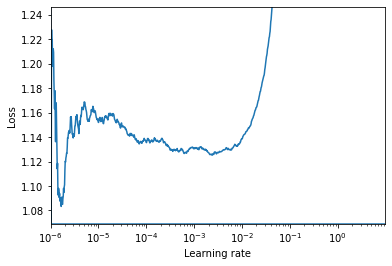

In [34]:
rec4_model = load_model(PRETRAINED_MODEL_PATH, 270)

# get rates and losses
rates, losses = find_learning_rate(rec4_model, train_set, NUM_TRAINING_IMAGES, 
                                   epochs=1, batch_size=BATCH_SIZE)
plot_lr_vs_loss(rates, losses, 1.9)

In [35]:
# define new learning rate scheduler callback
LR_START = 5e-5
LR_MAX = 1e-4
LR_MIN = 5e-5
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_270'
tboard_callback = keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, 
                                              profile_batch=(625, 645))
rec4_model = load_model(PRETRAINED_MODEL_PATH, 270)
rec4_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                   metrics=["sparse_categorical_accuracy"])
history4 = rec4_model.fit(train_set, epochs=15, validation_data=valid_set,
                        callbacks=[lr_callback, tboard_callback])

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-05.
1006/1006 [==============================] - 659s 643ms/step - loss: 1.0088 - sparse_categorical_accuracy: 0.7258 - val_loss: 0.7871 - val_sparse_categorical_accuracy: 0.7889
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 6e-05.
1006/1006 [==============================] - 645s 638ms/step - loss: 0.7709 - sparse_categorical_accuracy: 0.7876 - val_loss: 0.7315 - val_sparse_categorical_accuracy: 0.8064
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 7.000000000000001e-05.
1006/1006 [==============================] - 641s 633ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.8160 - val_loss: 0.7128 - val_sparse_categorical_accuracy: 0.8104
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 8e-05.
1006/1006 [==============================] - 643s 636ms/step - loss: 0.5488 - sparse_categorical_accuracy: 0.8431 - val_loss: 0.7103 - val_

In [36]:
rec4_model.evaluate(test_set)

394/394 [==============================] - 106s 265ms/step - loss: 0.5737 - sparse_categorical_accuracy: 0.8721


[0.5737363696098328, 0.8720653653144836]

## The best model profile analysis
The model was dissected for the signs of nonoptimal run: gaps between training steps. In order to reduce them as well as further improve model performance the following actions were taken:
- The environment variable "TF_GPU_THREAD_MODE" was set to "gpu_private";
- number or callbacks were reduced to minimum;
- Mixed Precision was enabled;
- "steps_per_execution" parameter was configured for better performance.

In addition models trained with batch size of 32 and 64 were compared. As a result there was no test set accuracy loss with twice as big batch size and also overall training time was reduced.  

In [15]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

### Model pretrained with mixed precision policy on using batch size of 64

In [ ]:
# update data pipelines based on changed batch size
BATCH_SIZE = 64

train_set = prepare(train_set_raw, augmentation=True, shuffle=True)
valid_set = prepare(valid_set_raw)
test_set = prepare(test_set_raw)

In [42]:
# define a new model architecture
base_model = EfficientNetB3(include_top=False, pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3),
                            weights='../input/efficientnet-keras-noisystudent-weights-b0b7/noisystudent/noisy.student.notop-b3.h5')
dropout = keras.layers.Dropout(.5)(base_model.output)
dense = keras.layers.Dense(N_CLASSES)(dropout)
outputs = keras.layers.Activation('softmax', dtype='float32')(dense)
model = keras.Model(inputs=base_model.input, outputs=outputs)

# freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# define callbacks
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_base_64'
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs,
                                                 histogram_freq=1,
                                                 profile_batch=(500, 520))
e_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, 
                                       mode='auto', restore_best_weights=True, 
                                       min_delta=0.005)

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer='adam', 
              metrics=["sparse_categorical_accuracy"])

history = model.fit(train_set, epochs=50, 
                    validation_data=valid_set,
                    callbacks=[tboard_callback, e_stop])

Epoch 1/50
1006/1006 [==============================] - 468s 454ms/step - loss: 2.5324 - sparse_categorical_accuracy: 0.4403 - val_loss: 1.2656 - val_sparse_categorical_accuracy: 0.6775
Epoch 2/50
1006/1006 [==============================] - 445s 439ms/step - loss: 1.3550 - sparse_categorical_accuracy: 0.6478 - val_loss: 1.1358 - val_sparse_categorical_accuracy: 0.7039
Epoch 3/50
1006/1006 [==============================] - 455s 449ms/step - loss: 1.2406 - sparse_categorical_accuracy: 0.6712 - val_loss: 1.0868 - val_sparse_categorical_accuracy: 0.7140
Epoch 4/50
1006/1006 [==============================] - 456s 450ms/step - loss: 1.1940 - sparse_categorical_accuracy: 0.6819 - val_loss: 1.0562 - val_sparse_categorical_accuracy: 0.7174
Epoch 5/50
1006/1006 [==============================] - 457s 452ms/step - loss: 1.1588 - sparse_categorical_accuracy: 0.6910 - val_loss: 1.0340 - val_sparse_categorical_accuracy: 0.7258
Epoch 6/50
1006/1006 [==============================] - 454s 448ms/ste

In [43]:
model.save('model_64_pretrained.h5')

### Model pretrained with mixed precision policy on using batch size of 32

In [ ]:
# update data pipelines based on changed batch size
BATCH_SIZE = 32

train_set = prepare(train_set_raw, augmentation=True, shuffle=True)
valid_set = prepare(valid_set_raw)
test_set = prepare(test_set_raw)

In [16]:
# define a new model architecture to pretrain model with mixed precision policy on using batch size of 32
base_model = EfficientNetB3(include_top=False, pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3),
                            weights='../input/efficientnet-keras-noisystudent-weights-b0b7/noisystudent/noisy.student.notop-b3.h5')
dropout = keras.layers.Dropout(.5)(base_model.output)
dense = keras.layers.Dense(N_CLASSES)(dropout)
outputs = keras.layers.Activation('softmax', dtype='float32')(dense)
model = keras.Model(inputs=base_model.input, outputs=outputs)

# freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# define callbacks
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_base_32'
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs,
                                                 histogram_freq=1,
                                                 profile_batch=(500, 520))
e_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, 
                                       mode='auto', restore_best_weights=True, 
                                       min_delta=0.005)

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer='adam', 
              metrics=["sparse_categorical_accuracy"])

history = model.fit(train_set, epochs=50, 
                    validation_data=valid_set,
                    callbacks=[tboard_callback, e_stop])

Epoch 1/50
2012/2012 [==============================] - 466s 222ms/step - loss: 2.3390 - sparse_categorical_accuracy: 0.4659 - val_loss: 1.2066 - val_sparse_categorical_accuracy: 0.6839
Epoch 2/50
2012/2012 [==============================] - 437s 216ms/step - loss: 1.3105 - sparse_categorical_accuracy: 0.6570 - val_loss: 1.1019 - val_sparse_categorical_accuracy: 0.7062
Epoch 3/50
2012/2012 [==============================] - 438s 216ms/step - loss: 1.2298 - sparse_categorical_accuracy: 0.6742 - val_loss: 1.0693 - val_sparse_categorical_accuracy: 0.7139
Epoch 4/50
2012/2012 [==============================] - 443s 219ms/step - loss: 1.1835 - sparse_categorical_accuracy: 0.6834 - val_loss: 1.0409 - val_sparse_categorical_accuracy: 0.7214
Epoch 5/50
2012/2012 [==============================] - 438s 216ms/step - loss: 1.1667 - sparse_categorical_accuracy: 0.6865 - val_loss: 1.0296 - val_sparse_categorical_accuracy: 0.7256
Epoch 6/50
2012/2012 [==============================] - 438s 216ms/ste

In [17]:
model.save('model_32_pretrained.h5')

### Fine-tuning of pretrained models

In [ ]:
# update data pipelines based on changed batch size
BATCH_SIZE = 64

train_set = prepare(train_set_raw, augmentation=True, shuffle=True)
valid_set = prepare(valid_set_raw)
test_set = prepare(test_set_raw)

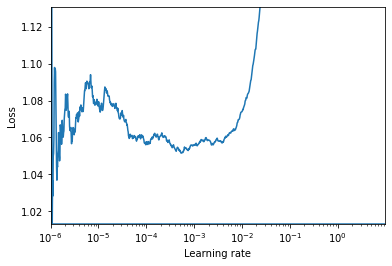

In [36]:
rec_model = load_model('../input/food101-pretr-model/model_64_pretrained.h5', 270)
rates, losses = find_learning_rate(rec_model, train_set, NUM_TRAINING_IMAGES, epochs=1, batch_size=BATCH_SIZE)
plot_lr_vs_loss(rates, losses, 1.8)

In [40]:
rec_model = load_model('../input/food101-pretr-model/model_64_pretrained.h5', 270)

# update learning rate scheduling callback
LR_START = 1e-5
LR_MAX = 1e-4
LR_MIN = 1e-5
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_64+270'
tboard_callback = keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, 
                                              profile_batch=(500, 520))

rec_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                metrics=["sparse_categorical_accuracy"])
history = rec_model.fit(train_set, epochs=15, validation_data=valid_set,
                        callbacks=[lr_callback])

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
1006/1006 [==============================] - 618s 600ms/step - loss: 0.9664 - sparse_categorical_accuracy: 0.7332 - val_loss: 0.8429 - val_sparse_categorical_accuracy: 0.7730
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.
1006/1006 [==============================] - 604s 598ms/step - loss: 0.8487 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.7730 - val_sparse_categorical_accuracy: 0.7940
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 4.6e-05.
1006/1006 [==============================] - 601s 594ms/step - loss: 0.7497 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.7609 - val_sparse_categorical_accuracy: 0.7992
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 6.4e-05.
1006/1006 [==============================] - 601s 594ms/step - loss: 0.6624 - sparse_categorical_accuracy: 0.8131 - val_loss: 0.7174 -

In [41]:
# evaluation of the model trained using mixed precision with batches of size 64 resuls in 88.09% accuracy
rec_model.evaluate(test_set)

394/394 [==============================] - 104s 262ms/step - loss: 0.5152 - sparse_categorical_accuracy: 0.8809


[0.5152424573898315, 0.8809486031532288]

In [ ]:
# update data pipelines based on changed batch size
BATCH_SIZE = 32

train_set = prepare(train_set_raw, augmentation=True, shuffle=True)
valid_set = prepare(valid_set_raw)
test_set = prepare(test_set_raw)

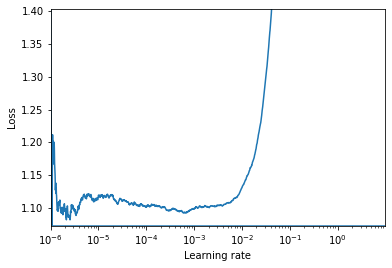

In [25]:
rec_model = load_model('../input/food101-pretr-model/model_32_pretrained.h5', 270)
rates, losses = find_learning_rate(rec_model, train_set, NUM_TRAINING_IMAGES, epochs=1, batch_size=BATCH_SIZE)
plot_lr_vs_loss(rates, losses, 1.8)

In [27]:
rec_model = load_model('../input/food101-pretr-model/model_32_pretrained.h5', 270)

# define new learning rate scheduler callback
LR_START = 1e-5
LR_MAX = 1e-4
LR_MIN = 1e-5
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_32+270'
tboard_callback = keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, 
                                              profile_batch=(500, 520))

rec_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                metrics=["sparse_categorical_accuracy"])
history = rec_model.fit(train_set, epochs=15, validation_data=valid_set,
                        callbacks=[lr_callback, tboard_callback])

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
2012/2012 [==============================] - 779s 377ms/step - loss: 0.9975 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.8352 - val_sparse_categorical_accuracy: 0.7752
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.
2012/2012 [==============================] - 748s 370ms/step - loss: 0.8662 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.7608 - val_sparse_categorical_accuracy: 0.7972
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 4.6e-05.
2012/2012 [==============================] - 741s 367ms/step - loss: 0.7489 - sparse_categorical_accuracy: 0.7910 - val_loss: 0.7246 - val_sparse_categorical_accuracy: 0.8056
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 6.4e-05.
2012/2012 [==============================] - 734s 363ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.8178 - val_loss: 0.7263 -

In [28]:
# # evaluation of the model trained using mixed precision with batches of size 64 resuls in 88.03% accuracy
rec_model.evaluate(test_set)

789/789 [==============================] - 122s 153ms/step - loss: 0.5488 - sparse_categorical_accuracy: 0.8803


[0.5487895011901855, 0.8802677392959595]

In [15]:
rec_model = load_model('../input/food101-pretr-model/model_64_pretrained.h5', 270)

# update learning rate scheduling callback
LR_START = 1e-5
LR_MAX = 1e-4
LR_MIN = 1e-5
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_64+270'
tboard_callback = keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, 
                                              profile_batch=(500, 520))

rec_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                metrics=["sparse_categorical_accuracy"],
                 steps_per_execution=16)
history = rec_model.fit(train_set, epochs=15, validation_data=valid_set,
                        callbacks=[lr_callback])

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
1006/1006 [==============================] - 570s 567ms/step - loss: 0.9728 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.8408 - val_sparse_categorical_accuracy: 0.7724
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.
1006/1006 [==============================] - 567s 564ms/step - loss: 0.8516 - sparse_categorical_accuracy: 0.7660 - val_loss: 0.7766 - val_sparse_categorical_accuracy: 0.7921
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 4.6e-05.
1006/1006 [==============================] - 565s 562ms/step - loss: 0.7522 - sparse_categorical_accuracy: 0.7899 - val_loss: 0.7454 - val_sparse_categorical_accuracy: 0.8008
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 6.4e-05.
1006/1006 [==============================] - 563s 559ms/step - loss: 0.6557 - sparse_categorical_accuracy: 0.8144 - val_loss: 0.7289 -

In [16]:
rec_model = load_model('../input/food101-pretr-model/model_64_pretrained.h5', 270)

# update learning rate scheduling callback
LR_START = 1e-5
LR_MAX = 1e-4
LR_MIN = 1e-5
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + '_64+270'
tboard_callback = keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, 
                                              profile_batch=(500, 520))

rec_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', 
                metrics=["sparse_categorical_accuracy"],
                 steps_per_execution=32)
history = rec_model.fit(train_set, epochs=15, validation_data=valid_set,
                        callbacks=[lr_callback])

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
1006/1006 [==============================] - 576s 573ms/step - loss: 0.9644 - sparse_categorical_accuracy: 0.7347 - val_loss: 0.8441 - val_sparse_categorical_accuracy: 0.7728
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.
1006/1006 [==============================] - 566s 562ms/step - loss: 0.8492 - sparse_categorical_accuracy: 0.7638 - val_loss: 0.7701 - val_sparse_categorical_accuracy: 0.7960
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 4.6e-05.
1006/1006 [==============================] - 564s 561ms/step - loss: 0.7516 - sparse_categorical_accuracy: 0.7911 - val_loss: 0.7395 - val_sparse_categorical_accuracy: 0.8020
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 6.4e-05.
1006/1006 [==============================] - 565s 562ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.8138 - val_loss: 0.7174 -

In [17]:
rec_model.evaluate(test_set)

394/394 [==============================] - 96s 243ms/step - loss: 0.5070 - sparse_categorical_accuracy: 0.8816


[0.5070001482963562, 0.8815830945968628]